- 新闻自动化处理:
新闻内容自动提取及呈现    
输入任意的新闻网址，对其进行：    
1）抓取正文内容，对非中文内容进行清洗    
2）文章关键词     
3）文章摘要，即关键句    
4）词云可视化     
新闻来源：https://3w.huanqiu.com/


考虑要自动化处理的需求，所以直接封装为类。

目前仍有不足的是缺少有效的词性字典，jieba自带的词性库不准确。

In [1]:
ls

MQBI04_Lesson19_Action2_NewsAutomaticallyExtractedAndPresented.ipynb
msyh.ttf
word_flag.txt
word_flag.txt.md
wordcloud.jpg


In [2]:
import re

import jieba
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from jieba import posseg as pseg
from textrank4zh import TextRank4Keyword, TextRank4Sentence

开始加载新闻......
新闻加载完毕！
该新闻中的人物有： {'布赖森', '弗曼', '鲍威尔', '马克', '白宫', '许缘', '高攀', '贾森', '顾问', '封锁', '熊茂伶'}
该新闻中的地点是： {'美国', '华盛顿'}
关键词：
经济 0.03959954169319202
美国 0.03712957331423831
疫情 0.024671105210752865
去年 0.009552790027605468
财政 0.0083560640681777
萎缩 0.008312372808476444
今年 0.008175902122957972
需要 0.007884559068281265
增长 0.007774250194632316
表示 0.007641591944716732
复苏 0.007541467228495896
实现 0.007519266103888913
未来 0.007408035804395028
经济学家 0.007130207692015823
能否 0.007080099430607495
显示 0.007037918258185984
距离 0.007019189121063794
措施 0.006910428019832805
保持 0.006894910396235057
就业 0.00688146878403323
新闻摘要如下：
10 0.06052675338913928 富国银行证券首席经济学家杰伊·布赖森表示，由于去年11月、12月疫情反弹，美国一些州重新出台封锁限制措施，许多民众自愿保持社交距离，个人消费支出遭到拖累，美国经济在去年底已失去增长动能
11 0.05426355778009324 美国联邦储备委员会日前结束今年首次货币政策例会后发表声明说，近几个月来，美国经济活动和就业复苏步伐有所放缓，受疫情冲击最为严重的部门尤其低迷
19 0.05597524304533672 鉴于近期美国疫情形势并未明显改善，布赖森预计今年第一季度美国经济增长将与去年第四季度大体持平，未来几个季度经济增长将取决于疫情走势和疫苗接种进展

根据词频，开始生成词云!


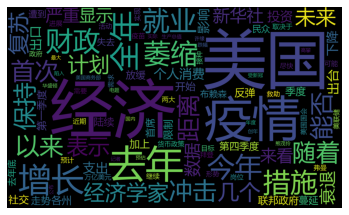

In [12]:
class MySpider:
    """
    用于爬取 国际新闻—环球独家 下的新闻，新闻ULR格式：https://world.huanqiu.com/article/XXXX
    """
    def __init__(self):
        self.header = {
            "user-agent":
            "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.96 Safari/537.36"
        }

    def crawler(self, url):
        """爬取新闻正文内容"""
        # 粗体打印
        print('\033[1m' + "开始加载新闻......")
        res = requests.get(url, headers=self.header)
        res.encoding = 'utf-8'
        contents = None
        if res.status_code == 200:
            soup = BeautifulSoup(res.text, "html.parser")
            # 定位"section"标签下的所有标签为p的tag
            contents = [tag.text for tag in soup.select("section p")]
            contents = "".join(contents)
            print("新闻加载完毕！")
        else:
            print(f"新闻加载遇到异常，状态码: {res.status_code}")
        return contents


class VisualNews:
    def __init__(self, article):
        self.stop_words = ['的', '了', '是', '月', '日']
        self.article = article
        self.get_name_and_place()

    def get_name_and_place(self):
        jieba.add_word("明显改善", tag='v')  # 副形词
        jieba.add_word("关键因素", tag='n')
        jieba.add_word("熊茂伶", tag='nr')
        jieba.add_word("布赖森", tag='nr')
        jieba.add_word("弗曼", tag='nr')
        words = pseg.lcut(self.article)
        names = {word for word, flag in words if flag == 'nr'}
        places = {word for word, flag in words if flag == 'ns'}
        print("该新闻中的人物有：", names)
        print("该新闻中的地点是：", places)

    def remove_stopwords(self, string):
        stop_words = self.stop_words
        for stop_word in stop_words:
            string = string.replace(stop_word, '')
        return string

    def preprocess_text(self):
        # 仅保留中文和标点符号
        contents = "".join(re.findall("[\u4e00-\u9fa5。，？！：]", self.article))
        contents = self.remove_stopwords(contents)
        cut_text = jieba.cut(contents)
        cut_text = " ".join(cut_text)
        return cut_text

    def my_get_key_words(self):
        """获取新闻关键词"""
        text = self.article
        # 输出关键词，设置文本小写，窗口为2
        tr4w = TextRank4Keyword()
        tr4w.analyze(text=text, lower=True, window=3)
        print('关键词：')
        for item in tr4w.get_keywords(20, word_min_len=2):
            print(item.word, item.weight)

    def my_get_key_setences(self):
        """获取新闻摘要"""
        # 输出重要的句子
        tr4s = TextRank4Sentence()
        tr4s.analyze(text=self.article, lower=True, source='all_filters')
        print('新闻摘要如下：')
        # 重要性较高的三个句子
        # tr4s.get_key_sentences()返回的是嵌套字典的列表
        top3sentence_lst = tr4s.get_key_sentences(num=3)
        # 按照index顺序对top3句子进行排序
        top3sentence_lst = sorted(top3sentence_lst, key=lambda x: x['index'])
        for item in top3sentence_lst:
            # index是语句在文本中位置，weight表示权重
            print(item.index, item.weight, item.sentence)

    # 生成词云
    def create_word_cloud(self, max_words=100, sav_png="wordcloud.jpg"):
        cut_text = self.preprocess_text()
        print('\n根据词频，开始生成词云!')
        wc = WordCloud(
            max_words=max_words,
            width=2000,
            height=1200,
            collocations=False,
            font_path='msyh.ttf',
        )
        wordcloud = wc.generate(cut_text)
        # 写词云图片
        wordcloud.to_file(sav_png)
        # 显示词云文件
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()


if __name__ == "__main__":
    URL = "https://world.huanqiu.com/article/41iWlHaX3ae"
    spider = MySpider()
    article = spider.crawler(URL)
    if article:
        visualize = VisualNews(article)
        visualize.my_get_key_words()
        visualize.my_get_key_setences()
        visualize.create_word_cloud()